[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Mayo-Radiology-Informatics-Lab/MIDeL/blob/main/chapters/6A.ipynb)

*Author: Bardia Khosravi, MD*

# 1. **Introduction**

Now that we know the basics of python programming and how to work with medical images, we will start building towards our first deep learning task. The following four chapters will walk through the steps to create a model that detects pneumonia from chest x-ray (CXR) images. To begin training a model, we first need to prepare our data. We will use a CXR dataset comprised of images from normal and pneumonia cases ([source](https://data.mendeley.com/datasets/rscbjbr9sj/2)). Though preparing data looks pretty straightforward, it is the source of many errors and sub-optimal performance that might occur during the training process. In this chapter and the next one, we go over the basic steps of preparing our data for training, and then in chapters 8 and 9, we will train our first model to classify CXR images based on their existing pathology. 

# 2. **Preprocessing**

In chapter 4, we saw that images are composed of pixels, which consist of numbers corresponding to the intensity of that specific pixel. But before we can feed images to our deep learning model, we often need to preprocess them. Preprocessing involves manipulating the image data to ensure that our model can handle the data (e.g. make sure they all have the same dimensions) or enhance its performance (e.g. consistent intensity ranges). This section will cover four common preprocessing steps that can help you during your deep learning journey. 

## 2.1. **Upsampling**

Image upsampling, also called interpolation, is the process of increasing the number of pixels of an image while maintaining the spatial coverage. For example, suppose that a chest x-ray image is represented by 512 pixels in width and 486 pixels in height. You can do upsampling to have the same image be represented by 512 pixels in each dimension. One very common use case of upsampling is when you work with 3D images, like CT scans, and the spatial resolution of the three axes is different. For example, the pixels in the x and y axes (width and height dimensions of a slice) may have a spacing of 1 mm (between the center of each pixel) while the space between slices (z-axis), also called slice thickness, is 3 mm (the distance between the center of each slice is 3 mm). In this situation, you might want to create intermediary slices so that the overall slice thickness would be 1 mm. Note that technically, the dimension of a pixel could be less than the spacing, in which case there is tissue between the pixels that is not sampled. We also note here that the term 'voxel' is often used to refer to pixels of a 3D image dataset.


There are several techniques to do upsampling, including nearest neighbor and bilinear interpolation. Figure 1 demonstrates the mathematical logic behind these techniques. 

<br><img src="https://i.ibb.co/jwbP1Bw/Fig1.png" alt="Figure 1" style='margin:auto' border="0"><u><br><b>Figure 1.</b> Traditional Interpolation Methods</u><br><br>

As you see in Figure 1, the linear method creates smoother images compared to the nearest neighbor method.

Fortunately, the deep learning frameworks and packages that we work with have implemented these methods, and so we don't need to code them ourselves. We only have to know what method to use for each input image. For image upscaling, we usually use the bilinear or bicubic (like bilinear interpolation, but rather than using a linear function, it uses a polynomial one to create intermediary pixel values) methods. However, we use the nearest neighbor method to preserve label values during interpolation when we want to upscale segmentation masks (discussed more in future chapters). Having said this, there are more advanced interpolation techniques like super-resolution that use deep learning to upscale images very realistically. There are some variations of these models available for medical images that create thin sliced MRI images, from thick sliced studies, by realistically interpolating the intermediary slices ([source](https://arxiv.org/abs/2106.02599)).



## 2.2. **Downscaling**

Downscaling (also known as decimation) is the opposite of upscaling, meaning that in this process, we decrease an image’s dimensions while still covering the same spatial extent. Downscaling is a handy preprocessing step as deep learning models work on images with identical sizes, meaning that all of our images that are used for training a deep learning model have to have the same dimensions. Moreover, our hardware usually limits the maximum image size that we can feed into our models, with larger images needing more GPU memory than smaller images, thus necessitating downscaling.

'Resizing' can perform either upscaling or downscaling, and is the name used in many image processing libraries. It typically expects the X and Y dimensions that are desired, and the interpolation method to be used.

## 2.3. **Registration**

As discussed in chapter 3, medical images have different modalities (e.g., x-ray, CT, MRI), and each modality might have different subtypes (e.g., MRIs have different sequences like T1, T2, FLAIR, etc. and there may be images without or with intravenous contrast). Each of these different subtypes can give us information about different tissues or pathologies; hence, combining them can provide our model with more information that can improve its performance (which is why radiologists acquire them). One crucial problem is that patients don’t have the exact same position when they acquire different images; for example, between brain MRI sequences, a patient may change their head position or move a little upwards on the imaging bed. This means that the two sequences will not be completely aligned when they are overlaid on top of each other. The process of spatially aligning images is called registration. Figure 2 shows an example of registering head CT to the same patient’s MRI.

<br><img src="https://i.ibb.co/Z1ck6VT/Fig2.jpg" alt="Figure 2" style='margin:auto' border="0"><u><br /><b>Figure 2.</b>  CT (magenta) to T1-MRI (green) registration ([source](https://www.researchgate.net/publication/308322242_EVolution_an_Edge-based_Variational_method_for_non-rigid_multi-modal_image_registration/figures?lo=1))</u><br><br>

There are some popular tools available for image registration, like [FSL](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/FLIRT), as well as some deep learning based models that find and match specific key points in different images and align them over each other ([source](https://arxiv.org/abs/1711.01666)).

## 2.4. **Segmentation**

For some problems, you might want to segment your image before training the model. One case might be where you need to segment the image in order to train the AI to segment the image; another use would be to remove/black out some parts of an image so that the model only 'sees' a specific part of an image. For example, you want your model to predict if an adrenal tumor is malignant or benign, you might want to segment the tumor and only feed those pixels to your model rather than the whole abdominal CT scan. Image segmentation can be done using software like [RIL-Contour](https://gitlab.com/Philbrick/rilcontour), [3D-slicer](https://www.slicer.org/), and [ITKSnap](http://www.itksnap.org/pmwiki/pmwiki.php). The final product of the segmentation is a mask that shows where a specific object is located. These masks can be used to train a segmentation model or be used for other purposes while training a model.

# 3. **Tensors, PyTorch and MONAI**

Now that we know some of the pre-processing steps used on medical images, we can start building our pneumonia detection pipeline. Before starting to code our pipeline, we have to note that deep learning models work with a special data format called *tensors*. 

A Tensor is not a familar term to most outside the deep learning community, but it is really just a fancy word for an N-dimensional array. A popular Python library for working on arrays is called numpy (https://numpy.org), but unfortunately, the way the numbers are represented aren't quite the same. Tensors are very similar to numpy arrays, but they can save the *history* of the operations that they go through. For example, if we multiply a tensor by ten then get the natural logarithm of that tensor, all of these operations will be saved in a special place in that tensor. This *history* is then used to calculate the gradient of the values of that tensor in order to optimize the training process. Don't worry if this last sentence does not make that much sense; we will discuss this in more detail in Chapter 9.

Several frameworks handle tensors and the workflow of deep learning models, including [Tensorflow](https://www.tensorflow.org/), [PyTorch](https://pytorch.org/), and [Jax](https://jax.readthedocs.io/en/latest/). Throughout this series, we will work with the PyTorch framework as it has an easier learning curve and it highly resembles native python programming. We will also use the MONAI (https://monai.io) framework, which is built on top of PyTorch but has many special utilities for medical images. To start working with PyTorch, we first have to install it. To install the latest version of PyTorch, you can head [here](https://pytorch.org/get-started/locally/), select your operating system and installation type. 


---


> **Note**: There is currently no GPU support for the macOS. So select "CPU" for the computing platform. If you have a local GPU and using Linux or Windows, you can use the "CUDA" installation. ***If you are using Colab, you do not need to install PyTorch as it is already available to you.***


---

First, let's start with importing PyTorch and see if we have a GPU available to use:

In [1]:
import torch

torch.cuda.is_available()  # Checking if CUDA (GPU inteface) is availabe

True

If you see `False` as the output of the last cell, it means that torch cannot access your GPU. If you are using colab, make sure that your runtime is using GPU; from the top toolbar, select *Runtime* -> *Change runtime type*.

We can easily convert a python list or numpy array to a PyTorch tensor:


In [2]:
import numpy as np

sample_list = [10, 20, 30, 40]
sample_array = np.arange(10, 20)

print("Sample List:", sample_list)
print("Sample Numpy Array:", sample_array)

Sample List: [10, 20, 30, 40]
Sample Numpy Array: [10 11 12 13 14 15 16 17 18 19]


In [3]:
sample_tensor1 = torch.tensor(sample_list)
sample_tensor2 = torch.tensor(sample_array)

print("Sample Tensor 1:", sample_tensor1)
print("Sample Tensor 2:", sample_tensor2)

Sample Tensor 1: tensor([10, 20, 30, 40])
Sample Tensor 2: tensor([10, 11, 12, 13, 14, 15, 16, 17, 18, 19])


We can get the shape of a tensor just like a numpy array:

In [4]:
sample_tensor1.shape

torch.Size([4])

We can see that `sample_tensor1` has one dimension with four elements. We can create random tensors with an arbitrary shape like this:

In [5]:
random_tensor = torch.randn((3, 512, 512))
random_tensor.shape

torch.Size([3, 512, 512])

Pytorch was initially developed as a low-level framework, meaning that you can change the details of the code with a very fine level of detail, but this necessitated coding every part of the program line by line. Several libraries with mid- and high-level interfaces have been developed on top of PyTorch by third-party developers to address this for beginner-level researchers and enthusiasts. One of these libraries developed with medical imaging research in mind is [MONAI](https://monai.io/). We will work with MONAI to do our first deep learning project throughout the following few chapters.

To start working with MONAI, we first have to install its latest version using:

```
pip install monai
```

This command can be run in the anaconda prompt, terminal (above), or in your notebook like this (below). Remember you can run commands from within notebooks by putting the exclamation character (!) at the start of the command.

In [6]:
!pip install monai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 31.2 MB/s eta 0:00:00


Now that we have MONAI installed, we can import it and start our pneumonia classification journey.

In [7]:
import monai

print("Installed MONAI Version is", monai.__version__)

Installed MONAI Version is 1.1.0


MOANI provides a unique dictionary-based pipeline that we will use throughout this chapter to read, preprocess, and *augment* our images. We often use the term 'pipeline' to refer to the series of steps that are performed on the images.

# 4. **Pneumonia Classification: Preparing Data**

To start with any project, we first have to get access to our data. We have prepared a set of data in the cloud, and you can download it using the 'gdown' command:

In [12]:
import os
import gdown

if not os.path.isdir("chest_xray"):
    gdown.download(
        "https://drive.google.com/uc?export=download&confirm=pbef&id=1L8ox5fIwb_PijLcPEofQyhe3oGiYESO2",
        "chest_xray.zip",
    )
    !unzip -q chest_xray.zip
    os.remove("chest_xray.zip")

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1L8ox5fIwb_PijLcPEofQyhe3oGiYESO2
To: /content/chest_xray.zip
100%|██████████| 1.24G/1.24G [00:04<00:00, 253MB/s]


If you don't have the folder explorer window open to the left, click on the folder icon (the bottom of the 4 icons to the left of this window). You can see the folders visible to your jupyter notebook. 
If we look at the "chest_xray" folder, we see that we have two different folders, one for training and one for testing. We will discuss why we need these two sets in the next chapter. In each of these folders, we have a folder containing normal CXRs and another folder containing pneumonia cases.

Let's create a list of dictionaries for all the available training images, where each dictionary contains the path and label for each image:

In [13]:
train_list = []

for label_idx, label in enumerate(["NORMAL", "PNEUMONIA"]):
    for image_path in os.listdir(f"/content/chest_xray/train/{label}"):
        train_list.append(
            {
                "img": f"/content/chest_xray/train/{label}/{image_path}",
                "label_name": label,
                "label_idx": label_idx,
            }
        )

print("Normal Examples:")
print(*train_list[:3], sep="\n")
print("\n")
print("Pneumonia Examples:")
print(*train_list[-3:], sep="\n")

Normal Examples:
{'img': '/content/chest_xray/train/NORMAL/NORMAL2-IM-0424-0001.jpeg', 'label_name': 'NORMAL', 'label_idx': 0}
{'img': '/content/chest_xray/train/NORMAL/NORMAL2-IM-0673-0001.jpeg', 'label_name': 'NORMAL', 'label_idx': 0}
{'img': '/content/chest_xray/train/NORMAL/IM-0545-0001-0002.jpeg', 'label_name': 'NORMAL', 'label_idx': 0}


Pneumonia Examples:
{'img': '/content/chest_xray/train/PNEUMONIA/person1418_bacteria_3638.jpeg', 'label_name': 'PNEUMONIA', 'label_idx': 1}
{'img': '/content/chest_xray/train/PNEUMONIA/person1074_bacteria_3012.jpeg', 'label_name': 'PNEUMONIA', 'label_idx': 1}
{'img': '/content/chest_xray/train/PNEUMONIA/person260_virus_541.jpeg', 'label_name': 'PNEUMONIA', 'label_idx': 1}


---


> **Python Notes**: <br>
1. Remember 'slicing' where you can get portions of a list or array. Here we use `[:3]` which means we start at the beginning (index 0) and go up to (but not including) index 3, so items at 0, 1, and 2. Then we print out the last 3 items using the `[-3:]` technique.<br>
2. Note also the asterisk (`*`) before the `train_list[:3]` does **list unpacking**, which means the items inside it replace that list. The above code is short for:
> 
> ```python
print(train_list[0], train_list[1], train_list[2])
```
> You might also want to try removing the `*` and see what you get.<br>
3. Finally, we have the **sep="\n"** as an additional argument (information supplied to a function call). This tells the print function to separate each item in the list with '\n' which is the newline character (like the return key).

---

In the above list, we also encoded the image labels as 0 (for normal images) and 1 (for pneumonia images).

The next step would be opening some of the images and viewing their size. We can define a function that gets an item of our list and shows our image and its size: (note that creating the function does NOT call the function).

In [14]:
from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline


def get_item_info(item: dict) -> None:
    image_path = item["img"]
    label = item["label_name"]
    label_idx = item["label_idx"]

    image_file = Image.open(image_path)
    image_array = np.array(image_file)

    plt.title(f"label: {label} ({label_idx}); size: {image_array.shape}")
    plt.imshow(image_file, cmap="gray")
    plt.show()

Now that we have our function, we can visualize a sub-sample of our images:

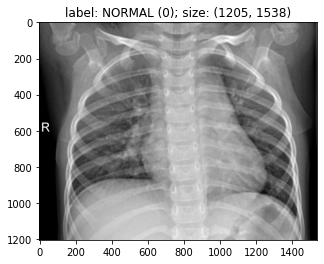

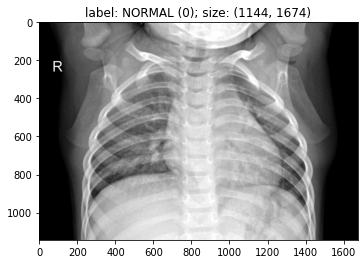

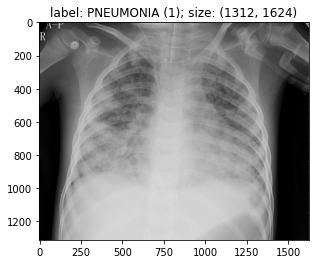

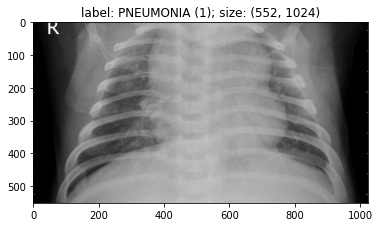

In [15]:
for i in [0, 17, -23, -1]:
    get_item_info(train_list[i])

As you see, these images have different sizes, which poses a problem for our model (it requires that all inputs be the same size). One way to address this problem is to resize all images using the PIL library, just as we did in chapter 4, and save them in a separate directory and use that data for training our model. The other approach is to do it on the fly. MONAI can help us with these types of data *transformations*. Transformation is the general term that implies any change to our data. MONAI has lots of dictionary-based transformations that can be applied to a group of images. For the rest of this chapter, we will use the list of dictionaries that we created (`train_list`) and some of these dictionary-based transformations that can be used to open, preprocess, and augment our images.

## 4.1. **Opening Images**

To open images using MONAI's dictionaries, we can use the `LoadImageD` transform; *the `D` at the end means it is a dictionary* and it also expects a dictionary and key to indicate what should be loaded. MONAI transformations are a part of the submodule `monai.transforms`, and we have to import them into our program before using them.


In [16]:
from monai.transforms import LoadImageD

Each transform is a class that we first have to initialize by providing some configuration and then use them as a function. During the intialization of dictionary-based transforms, we have to define the specific dictionary key(s) for the transformations that should occur.

In [17]:
image_reader = LoadImageD(keys=["img"])

In the above line, we have initialized the `LoadImageD` transform by defining that we want the transformation (image loading in this case) to happen on the items with the `img` key of the dictionary that is passed to it. This transformation automatically detects the type of image that we are trying to load and uses appropriate libraries to do so. It supports the following formats: png, jpg, dcm, nii, nii.gz, and npz.

Now that we have initialized our transform, we can pass a dictionary to it and see what happens:

In [18]:
sample_image = image_reader(train_list[0])
sample_image

{'img': tensor([[69., 66., 68.,  ...,  0.,  0.,  0.],
         [71., 71., 75.,  ...,  0.,  0.,  0.],
         [73., 73., 76.,  ...,  0.,  0.,  0.],
         ...,
         [76., 74., 76.,  ...,  0.,  0.,  0.],
         [79., 78., 78.,  ...,  0.,  0.,  0.],
         [84., 84., 85.,  ...,  0.,  0.,  0.]]),
 'label_name': 'NORMAL',
 'label_idx': 0,
 'img_meta_dict': {'format': 'JPEG',
  'mode': 'L',
  'width': 1538,
  'height': 1205,
  spatial_shape: array([1538, 1205]),
  original_channel_dim: 'no_channel',
  'filename_or_obj': '/content/chest_xray/train/NORMAL/NORMAL2-IM-0424-0001.jpeg',
  affine: tensor([[1., 0., 0., 0.],
          [0., 1., 0., 0.],
          [0., 0., 1., 0.],
          [0., 0., 0., 1.]], dtype=torch.float64),
  space: RAS}}

As we see, the `image_reader` took all the items in the dictionary with the `img` key and loaded them into sample_image (we only printed out information for the first one).  In other words, the transform used the `img` key as the path to an image, opened it and put its value into the receiving variable and note that it also retained the `img` key in this variable. We can also visualize this image:

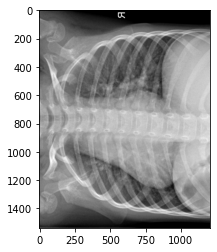

In [19]:
plt.imshow(sample_image["img"], cmap="gray");

The image's axes are switched, meaning that the height is width, and width is height. If MONAI doesn't have a transform we want, we can create similar dictionary-style transforms of our own. Let's write a custom transform to transpose our image back to its original form:

In [29]:
from typing import List
from monai.transforms import (
    MapTransform,
)  # Monai transforms should be sub-classed to the class Transform
import copy  # the copy library creates a copy of an object so we do not change it accidentally


class SwapXYD(MapTransform):
    def __init__(
        self, keys: List[str]
    ) -> None:  # initializing the class and getting the transformation key
        super().__init__(keys)

    def __call__(
        self, data
    ):  # the __call__ method is what is the main method that is executed when we use the transform
        d = dict(data)
        for key in self.key_iterator(d):
            d[key] = np.swapaxes(
                d[key], 1, 0
            )  # using numpy to swap axis 1 with 0, which are the X and Y axes.
        return d

Now we can create an instance of the `TransposeD` transform and pass the image we obtained from the reader and see the result:

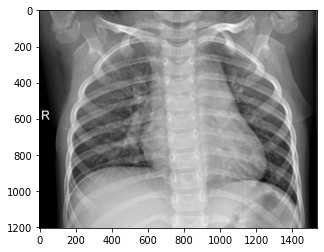

In [30]:
transposer = SwapXYD(keys=["img"])
transposed_image = transposer(sample_image)

plt.imshow(transposed_image["img"], cmap="gray");

We can see that our image has two dimensions, one for height and one for width.

In [31]:
transposed_image["img"].shape

(1205, 1538)

However, deep learning models need images to have an additional dimension for the 'channel'. In most cases, our images in medicine are gray-scale (single channel), meaning they do not have a color and they only have different levels of gray. Some medical images, like color Doppler US images are color and thus will have 3 color channels.

By default, PyTorch expects images to have this additional channel dimension, and that it should be the first dimension, *channel-first approach*. We can add a single dimension as the first dimension to our image using MONAI: 

In [32]:
from monai.transforms import AddChannelD

channel_adder = AddChannelD(keys=["img"])
channel_first_image = channel_adder(transposed_image)

channel_first_image["img"].shape

/usr/local/lib/python3.8/dist-packages/monai/utils/deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)


torch.Size([1, 1205, 1538])

Next, let's do some preprocessing on this image.

## 4.2. **Preprocessing Images**

As we mentioned before, our images do not have the same size, so we have to do upsampling or downsampling to transform all of our images to the same size. Fortunately, MONAI provides a `ResizeD` transform that handles both the upsampling and downsampling of images:

In [33]:
from monai.transforms import ResizeD

resizer = ResizeD(
    keys=["img"], spatial_size=(512, 512), mode=["bilinear"], align_corners=False
)
resized_image = resizer(channel_first_image)

resized_image["img"].shape

torch.Size([1, 512, 512])

Just to make sure, let's also visualize it:

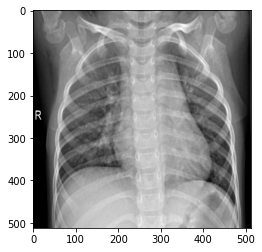

In [34]:
plt.imshow(resized_image["img"][0, :, :], cmap="gray");

---


> **Note**: Unfortunately, matplotlib only supports channel-last images, and even in that case, the image should have three channels to be displayed correctly. To solve this problem, we select all the content of the first (and only) channel (`resized_image["img"][0,:,:]`), essentially removing the channel dimension.


---

## 4.3. **Augmenting Images**

*Augmentation*, is the process of creating many variations from the training dataset, so the model learns the relevant information. For example, suppose that a patient is slightly rotated while taking the CXR. We want our model to learn instances of pneumonia regardless of any rotation of the patient since pneumonia will look about the same. We will cover augmentation in the following chapters in more detail, but, as a beginner, let's use MONAI to randomly rotate our images and see the results. We say randomly because we want our model to see a range of rotated images during training.

In [35]:
from monai.transforms import RandRotateD

rotor = RandRotateD(keys=["img"], range_x=0.17, prob=0.8)
# range_x shows how much rotation is allowed in radians (10 degrees = 0.17 radian),
# the number is picked up randomly between -0.17 to + 0.17 rads

# prob shows how probable it is to apply this transformation

rotated_image = rotor(resized_image)

Let's check if the output is randomly rotated every time:

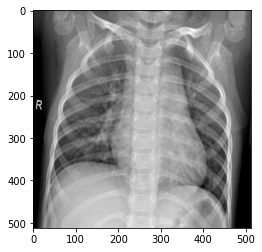

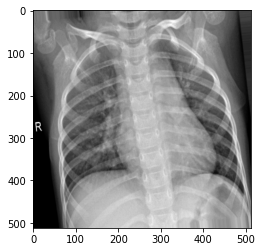

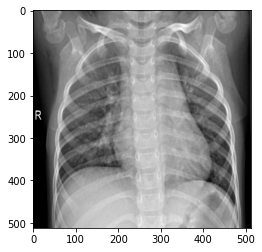

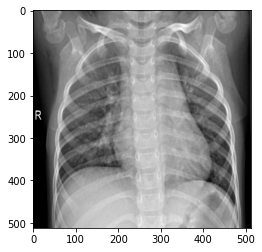

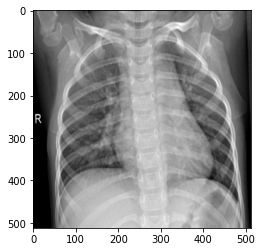

In [36]:
for i in range(5):
    rotated_image = rotor(resized_image)

    plt.imshow(rotated_image["img"][0, :, :], cmap="gray")
    plt.show()

There are many augmentations available in the MONAI package, like flipping, zooming, or translating images, which we will use in this series. 

The only thing left to do is to convert our image and label to tensors, and everything is ready to be fed into a model.

In [37]:
from monai.transforms import ToTensorD

to_tensor = ToTensorD(keys=["img", "label_idx"])
final_item = to_tensor(rotated_image)

print("Image type is", type(final_item["img"]))
print("Label type is", type(final_item["label_idx"]))

Image type is <class 'monai.data.meta_tensor.MetaTensor'>
Label type is <class 'monai.data.meta_tensor.MetaTensor'>


## 4.4. **Creating the Pipeline**

As you saw in the previous section, we have to use the output of a transformation as the input to the next one. To make coding easier, we can create a 'pipeline' that does exactly that:

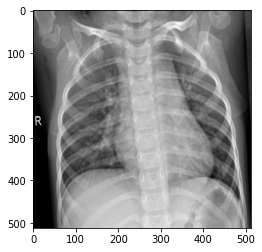

In [38]:
from monai.transforms import Compose, SelectItemsD

train_transforms = Compose(
    [
        LoadImageD(keys=["img"]),
        SwapXYD(keys=["img"]),
        AddChannelD(keys=["img"]),
        ResizeD(
            keys=["img"],
            spatial_size=(512, 512),
            mode=["bilinear"],
            align_corners=False,
        ),
        RandRotateD(keys=["img"], range_x=0.17, prob=0.8),
        ToTensorD(keys=["img", "label_idx"]),
        SelectItemsD(keys=["img", "label_idx", "label_name"]),
    ]
)

sample_image = train_transforms(train_list[0])
plt.imshow(sample_image["img"][0, :, :], cmap="gray");

The `Compose` class takes care of sequentially applying each transformation and passing the results of that to the next one.

---


> **Note**: MONAI saves the meta-data of all the transformations so that it can reverse them in the future if it needs. This makes our output very cluttered. As we are not interested in inverting these transformations for this task, we can select only the desired keys by using the `SelectItemsD` transform. To see the difference, you can print the `sample_image` variable with and without this transformation.


---

# 5. **Summary and Further Reading**

This chapter reviewed some of the preprocessing steps that can be applied to an image before being fed to a model. We also discussed what tensors are. Finally, we covered the basic steps of working with MONAI's transformations to read, preprocess and augment our images during training. Here are some of the resources that we think might be helpful for further reading:

*   [MONAI's transformations documentation](https://docs.monai.io/en/stable/transforms.html#dictionary-transforms): This contains the details of all the dictionary-based transformations that are available in MONAI.

`TO BE COMPLETED...`

---

##***Feedback***

*Now that you have completed this chapter, we would be very grateful if you spend a few minutes of your time to answer a short survey about this chapter. We highly value your feedback and will do our best to leverage this to improve our educational content and/or strategies.*

[Click here to begin the survey!](https://docs.google.com/forms/d/e/1FAIpQLSddhdaAmeHmrKKRNXCLIQH6_mnIC3KR7XlDIVWGt3FSQhPDhQ/viewform)